In [3]:
import matplotlib.pyplot as plt
import mudata; mudata.set_options(pull_on_update=False)
import muon as mu
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, singledispatchmethod, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch_cluster import knn
from torch_geometric import nn as gnn
from torch_geometric.nn.conv import GCNConv, SimpleConv, SGConv
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Asterism
from asterism.models.lda import GibbsLDA
from asterism.models.ntm import ATLAS, NTM, RSB
from asterism.utils import attrmethod, get_kwargs, kmeans, normalize, relabel, to_list
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, NORM, OPTIM, Encoder, MLP, RNN
from asterism.utils.figs import show_comparison, show_dataset

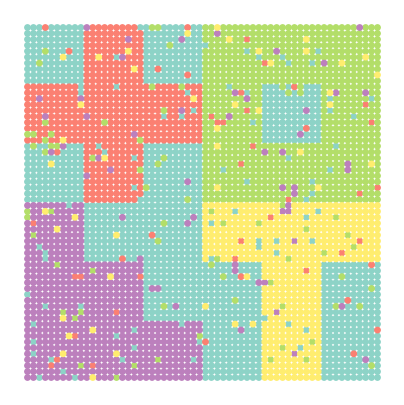

In [4]:
data, locs, labels = make_dataset(mix=.1)
show_dataset(locs, labels)

In [11]:
def _build_docs(locs, n_docs=-1, doc_size=32):
    sections, docs = np.unique(locs[:, 0]), []    

    for s in sections if locs.shape[-1] > 2 else locs[None, :, 0]:
        mask = locs[:, 0] == s
        n_docs_ = n_docs if n_docs != -1 else mask.sum()//4
        idx = np.random.permutation(mask.sum())[:n_docs_]
        locs_ = locs[mask, :3][idx]
        cdists = cdist(locs_[:, -2:], locs_[:, -2:], 'sqeuclidean')
        vars_ = np.sort(cdists, -1)[:, doc_size]
        docs.append(np.concat([locs_, vars_[:, None]], -1))

    docs = np.concat(docs, 0)

    return docs

def _build_data(X, locs, data_size=8):
    sections, data = np.unique(locs[:, 0]), []

    for s in sections if locs.shape[-1] > 2 else locs[None, :, 0]:
        mask = locs[:, 0] == s
        cdists = cdist(locs[mask, -2:], locs[mask, -2:], 'sqeuclidean')
        vars_ = np.sort(cdists, -1)[:, data_size]
        gauss = np.exp(-cdists/(2*vars_))/(np.sqrt(2*np.pi*vars_))
        data.append(gauss@X[mask])

    data = np.concat(data, 0)

    return data

class GibbsSLDA(Asterism):
    def __init__(self, n_topics=3, *, n_docs=-1, doc_size=4, data_size=4, vocab_size=32, dt_prior=1., tw_prior=1., desc='SLDA', seed=None):
        super().__init__(desc, seed)

        self.n_topics = n_topics
        self.n_docs = n_docs
        self.doc_size = doc_size
        self.data_size = data_size
        self.vocab_size = vocab_size
        self.dt_prior = dt_prior
        self.tw_prior = tw_prior

        self._n_steps = 100

    def _build_docs(self, locs):
        docs = _build_docs(locs, self.n_docs, self.doc_size)

        return docs
    
    def _build_data(self, X, locs):
        data = _build_data(X, locs, self.data_size)

        return data

    def _build(self, X, locs):
        self._locs = np.concat([np.zeros([locs.shape[0], 3 - locs.shape[-1]]), locs], -1)
        self._docs, data = self._build_docs(locs), self._build_data(X, locs)
        self.words_, n_docs = kmeans(data, self.vocab_size, verbosity=0), self._docs.shape[0]
        doc_range, topic_range = np.arange(n_docs)[None].T, np.arange(self.n_topics)[None].T
        self.docs_, self.topics_ = np.zeros((2, self._n_steps, X.shape[0]), dtype=np.int32)
        self.topics_[-1:] = self._seed.choice(self.n_topics, X.shape[0])
        self.dt_post_ = (self.docs_[-1] == doc_range)@np.eye(self.n_topics)[self.topics_[-1]]
        self.tw_post_ = (self.topics_[-1] == topic_range)@np.eye(self.vocab_size)[self.words_]

        return self
    
    def _query(self, idx):
        loc = self._locs[idx]
        doc = self.docs_[self._step_n - 1, idx]
        topic = self.topics_[self._step_n - 1, idx]
        word = self.words_[idx]

        return loc, doc, topic, word
    
    def _decrement(self, doc, topic, word, return_posts=False):
        self.dt_post_[doc, topic] -= 1
        self.tw_post_[topic, word] -= 1

        if return_posts:
            return self.dt_post_, self.tw_post_
        return self
    
    def _increment(self, doc, topic, word, return_posts=False):
        self.dt_post_[doc, topic] += 1
        self.tw_post_[topic, word] += 1

        if return_posts:
            return self.dt_post_, self.tw_post_
        return self
    
    def _sample_doc(self, loc, topic, return_probs=False):
        mask = self._docs[:, 0] == loc[0]
        cdists = cdist(loc[None, 1:], self._docs[mask, 1:3], 'sqeuclidean')[0]
        wd_probs = np.exp(-cdists/(2*self._docs[mask, -1]))
        dt_probs = self.dt_post_[mask, topic] + self.dt_prior
        dt_probs /= (self.dt_post_[mask] + self.dt_prior).sum(-1)
        probs = normalize(wd_probs*dt_probs)
        doc = self._seed.choice(mask.sum(), p=probs)

        if return_probs:
            return doc, probs
        return doc

    def _sample_topic(self, doc, word, return_probs=False):
        dt_probs = normalize(self.dt_post_[doc] + self.dt_prior)
        tw_probs = self.tw_post_[:, word] + self.tw_prior
        tw_probs /= (self.tw_post_ + self.tw_prior).sum(-1)
        probs = normalize(dt_probs*tw_probs)
        topic = self._seed.choice(self.n_topics, p=probs)

        if return_probs:
            return topic, probs
        return topic

    def _step(self):
        idx, likelihood = self._seed.permutation(self.words_.shape[0]), 0

        for i in idx:
            loc, doc, topic, word = self._query(i)
            self._decrement(doc, topic, word)
            new_doc, doc_probs = self._sample_doc(loc, topic, return_probs=True)
            new_topic, topic_probs = self._sample_topic(doc, word, return_probs=True)
            self._increment(new_doc, new_topic, word)
            self.docs_[self._step_n, i] = new_doc
            self.topics_[self._step_n, i] = new_topic
            likelihood += doc_probs[new_doc] + topic_probs[new_topic]

        return likelihood

    def _predict(self):
        burn_in = self._n_steps//2
        topics = mode(self.topics_[burn_in:]).mode

        return topics

SLDA: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


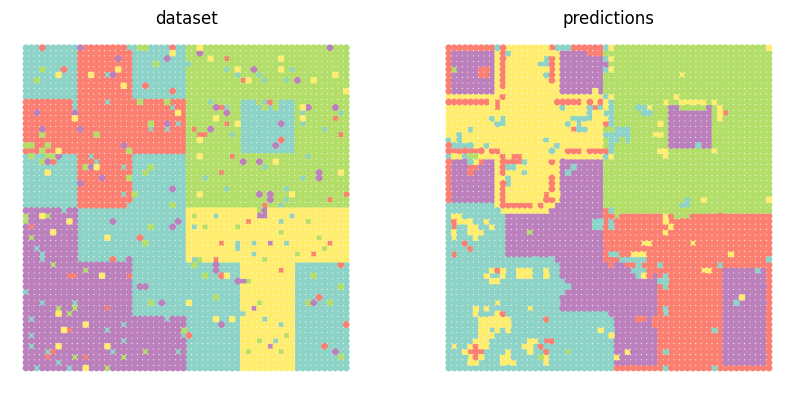

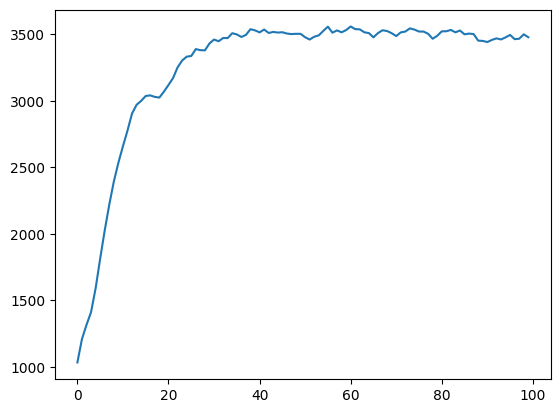

In [12]:
model = GibbsSLDA(5)
topics = model.fit_predict(data, locs=locs)
show_comparison(locs, labels, topics)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [10]:
model._X

array([[ 10.17018038, -15.03676572,  -8.63168553, ...,  16.02518163,
         -7.52906554,   0.68736921],
       [ 18.30722232,  -1.99260754,  -9.31742237, ...,  -1.69741306,
         -5.5817147 ,  10.71206594],
       [  7.37945579, -12.16064933,  -2.15248713, ...,   9.97758839,
        -13.90776616,  15.07544231],
       ...,
       [-12.55399221,  -3.38176604,   4.56855345, ..., -10.78215463,
         15.73668828, -19.70643148],
       [-12.35686783, -10.30832243,   5.47296581, ..., -12.24249889,
          2.30540927,  -8.4269253 ],
       [-16.36165514,  -4.40673241,  14.06259452, ..., -11.87325102,
         10.30095691,  -4.56851177]], shape=(3600, 100))

In [11]:
model._locs

array([[ 0., 30.],
       [ 0., 31.],
       [ 0., 32.],
       ...,
       [59., 27.],
       [59., 28.],
       [28., 59.]], shape=(3600, 2))

In [62]:
model.tw_post_.shape

(3, 32)

In [63]:
model.dt_post_.shape

(900, 3)

In [3]:
model = GibbsLDA()
model._build(data)

,n_topics,3
,doc_size,32
,vocab_size,32
,dt_prior,1.0
,tw_prior,1.0
,desc,'LDA'
,seed,None


In [4]:
model.docs_

array([[ 0,  0,  0, ...,  1,  0,  6],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  4,  2],
       ...,
       [31, 31, 31, ..., 31, 30, 31],
       [31, 31, 30, ..., 31, 31, 31],
       [30, 30, 31, ..., 29, 31, 31]], shape=(3600, 32), dtype=int32)

In [5]:
model.words_

array([ 0,  0,  0, ..., 29, 31, 31], shape=(115200,), dtype=int32)

KMeans: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


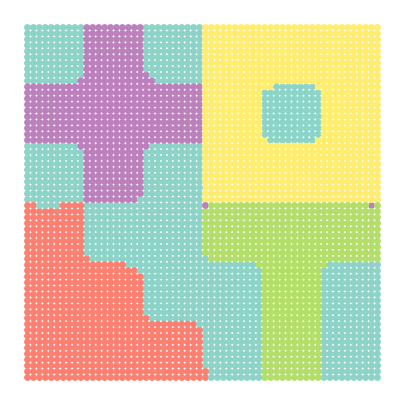

In [44]:
X = make_data(data, locs)
topics = kmeans(X, 5)
show_dataset(locs, topics)

In [ ]:
kmeans(X)

array([[  3.73229817,  22.19058241,  16.4535592 , ...,   6.72920714,
        -17.31835408,  21.09749606],
       [ 13.42915884,  21.39379416,  17.43995721, ...,  15.12680986,
        -21.49979512,  21.74986028],
       [ 17.46943326,  22.15255556,  18.1120707 , ...,  17.94234705,
        -23.01131492,  19.21477787],
       ...,
       [ 13.71711604, -16.05283169, -13.88112462, ...,  16.63330569,
        -19.8544145 , -21.32340036],
       [ 13.60787816, -18.25942268, -12.73228811, ...,  14.41169025,
        -24.57981238, -20.78932036],
       [  9.72820505, -18.74180464,  -5.19094273, ...,   2.98445125,
        -26.73018075, -20.28344156]], shape=(3600, 100))

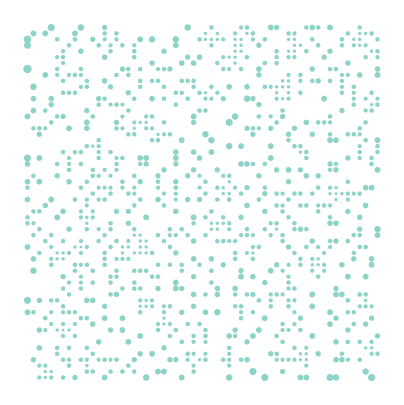

In [16]:
def distribute(locs, n_documents=None, scale=1., n_neighbors=4):
    sections = np.unique(locs[:, 0])
    documents = []

    for s in sections:
        mask = locs[:, 0] == s

        if n_documents is None:
            n_documents = mask.sum()//4

        idx = np.random.permutation(mask.sum())[:n_documents]
        doc_locs = locs[mask, :3][idx]
        proximity = cdist(doc_locs[:, 1:], doc_locs[:, 1:], 'sqeuclidean')
        variance = scale*np.sort(proximity, -1)[:, n_neighbors]
        documents.append(np.hstack([doc_locs, variance[None].T]))

    documents = np.vstack(documents)

    return documents

docs = distribute(locs)
show_dataset(docs[:, :-1], size=docs[:, -1])